# Benchmarki

Wszystkie obiliczenia wykonano z użyciem karty graficznej [NVIDIA Titan RTX](https://www.nvidia.com/content/dam/en-zz/Solutions/titan/documents/titan-rtx-for-creators-us-nvidia-1011126-r6-web.pdf) z 24GB VRAM i 4608 rdzeniami CUDA.

# Symulowana Bifurkacja


In [1]:
# Obliczenia potrzebne do benchmarku naszej implementacji

import os
import time
import pickle

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

from benchmarks import discrete_simulated_bifurcation_gpu, balistic_simulated_bifurcation
from IPython.utils.io import capture_output
from tqdm import tqdm
from benchmark_data import read_instance, chimera_data, pegasus_data, ROOT, zephyr_data
from math import inf

architecture = "zephyr"
data = chimera_data if architecture == "chimera" else pegasus_data if architecture == "pegasus" else zephyr_data
global_results = {}

gaps = []
times = []
for instance in tqdm(data):
    J, h = read_instance(instance.path, convention="minus_half")
    J2 = cp.asarray(J, dtype=cp.float32)
    h2 = cp.asarray(h, dtype=cp.float32)
    # kompilacja 
    with capture_output() as captured:
        states, energies = discrete_simulated_bifurcation_gpu(J2, h2, 100, 0.25, 2**5)

    result = inf
    gap = inf
    elapsed = 0
    count = 0
    best_result = 0
    start = time.time()
    with capture_output() as captured:
        states, energies = discrete_simulated_bifurcation_gpu(J2, h2, 5000, 0.5, 2**11, c_0_scaling=0.7)
    result = min(energies).item()
    checkpoint = time.time()
    elapsed = checkpoint - start
    gap = (instance.best_energy - result)/(instance.best_energy)

    # while gap >= 0.05 :
    #     with capture_output() as captured:
    #         states, energies = discrete_simulated_bifurcation_gpu(J2, h2, 1000 * (1 + count), 0.5, 2**11, c_0_scaling=0.7)
    #     result = min(energies).item()
        
    #     if result < best_result:
    #         best_result = result

    #     checkpoint = time.time()
    #     elapsed = checkpoint - start
    #     gap = (instance.best_energy - best_result)/instance.best_energy
    #     count += 1
            
    gaps.append(gap)    
    times.append(elapsed)



with open(os.path.join(ROOT, "wyniki", f"sbm_our_{architecture}_results.pkl"), "wb") as f:
    data = (times, gaps)
    pickle.dump(data, f)



100%|██████████| 5/5 [02:40<00:00, 32.06s/it]


In [3]:
# obliczenia potrzebne dla zewnętrzej implementacji
import os
import time
import pickle
import torch

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import simulated_bifurcation as sb

from IPython.utils.io import capture_output
from tqdm import tqdm
from benchmark_data import read_instance, chimera_data, pegasus_data, ROOT, zephyr_data
from math import inf, sqrt

architecture = "zephyr"
data = chimera_data if architecture == "chimera" else pegasus_data if architecture == "pegasus" else zephyr_data

gaps = []
times = []
for instance in tqdm(data):
    J, h = read_instance(instance.path, convention="dwave")
    N = len(h)
    J2 = torch.tensor(J, dtype=torch.float32, device=torch.device("cuda"))
    h2 = torch.tensor(h, dtype=torch.float32, device=torch.device("cuda"))

    mean_J = np.sqrt(np.sum(np.square(J)) / (N * (N - 1)) )
    c_0 = 0.5 / (mean_J * sqrt(N))

    result = inf
    gap = inf
    elapsed = 0
    count = 0
    best_result = 0
    start = time.time()

    with capture_output() as captured:
        sb.set_env(time_step=0.5)
        state, energy = sb.minimize(J2, h2, domain="spin", dtype=torch.float32, agents=2**11, mode="discrete", device=torch.device("cuda"))
    result = energy.item()
    checkpoint = time.time()
    elapsed = checkpoint - start
    gap = (instance.best_energy - result)/instance.best_energy

    # while gap >= 0.05 :
    #     with capture_output() as captured:
    #         sb.set_env(time_step=0.5)
    #         state, energy = sb.minimize(J2, h2, domain="spin", dtype=torch.float32, agents=2**11, mode="discrete", device=torch.device("cuda"))
    #     result = energy.item()
        
    #     if result < best_result:
    #         best_result = result

    #     checkpoint = time.time()
    #     elapsed = checkpoint - start
    #     gap = (instance.best_energy - best_result)/instance.best_energy
    #     count += 1
            
    gaps.append(gap)    
    times.append(elapsed)


with open(os.path.join(ROOT, "wyniki", f"sbm_external_{architecture}_results.pkl"), "wb") as f:
    data = (times, gaps)
    pickle.dump(data, f)

/home/tsmierzchalski/anaconda3/envs/szkolenia/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 5/5 [04:34<00:00, 54.83s/it]


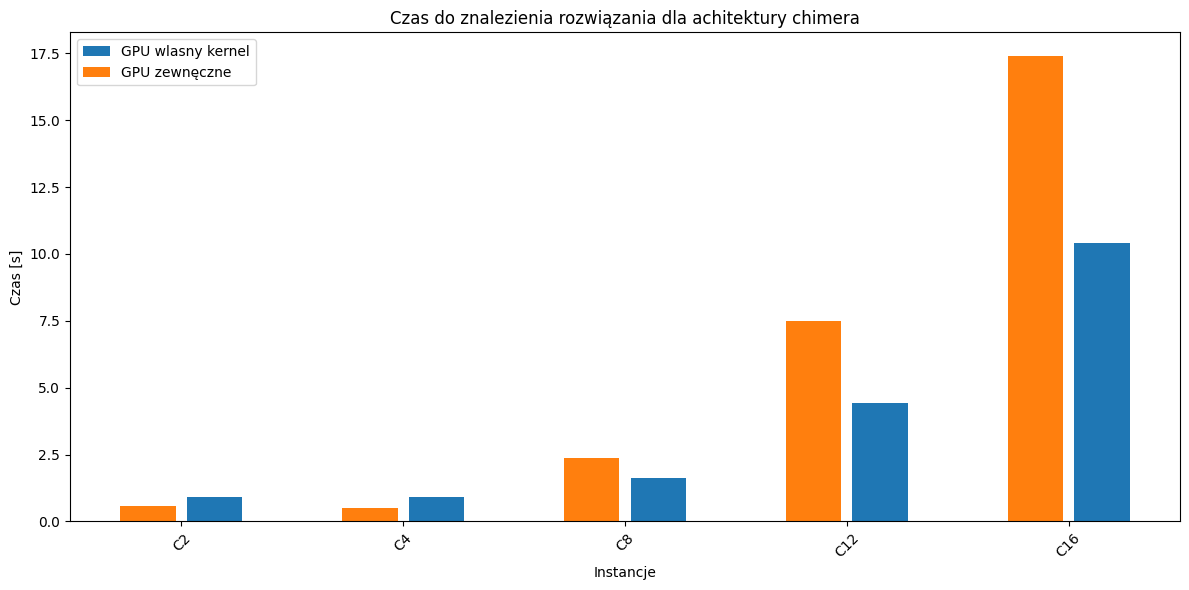

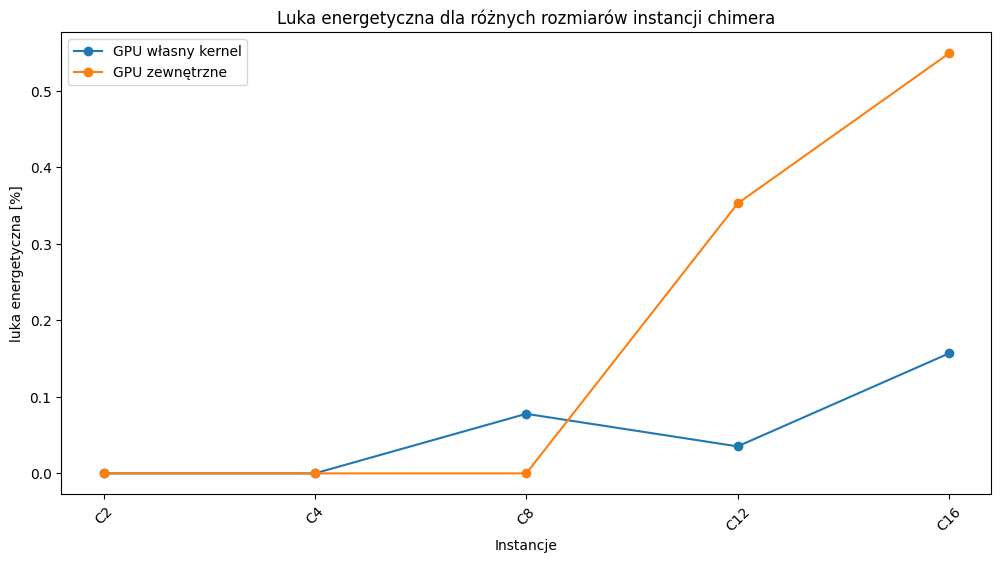

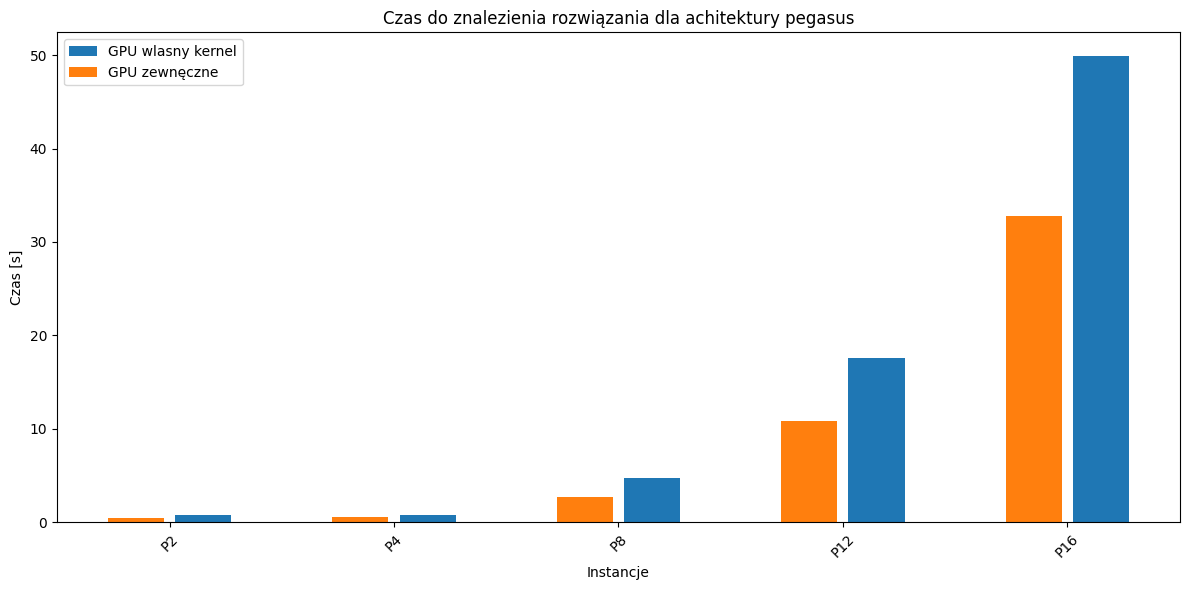

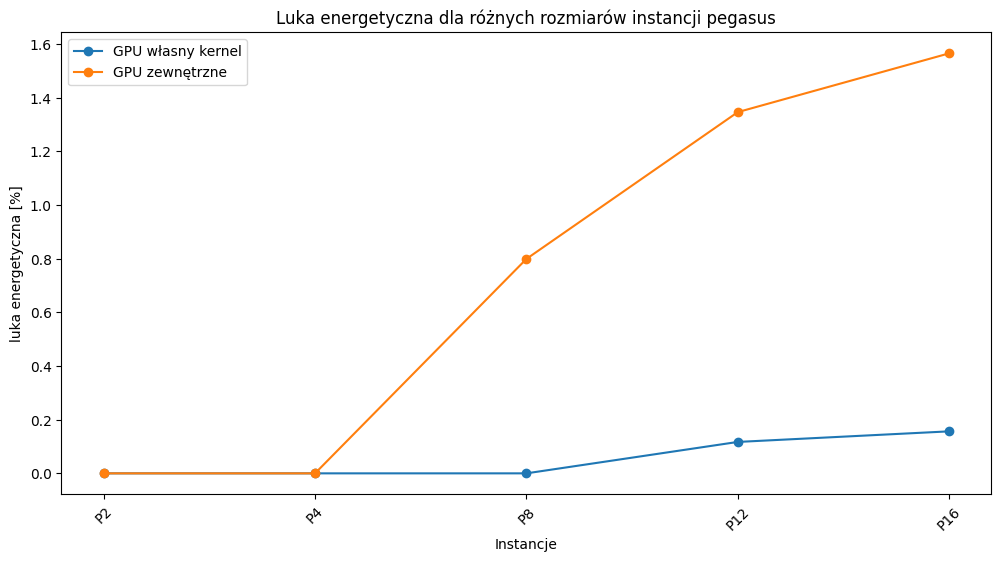

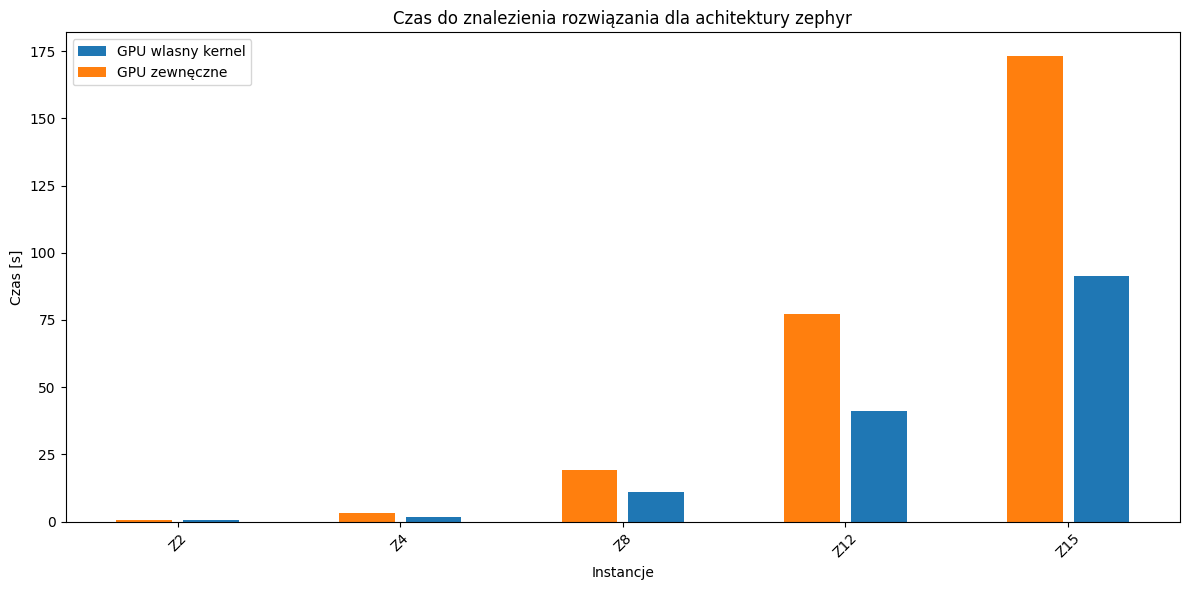

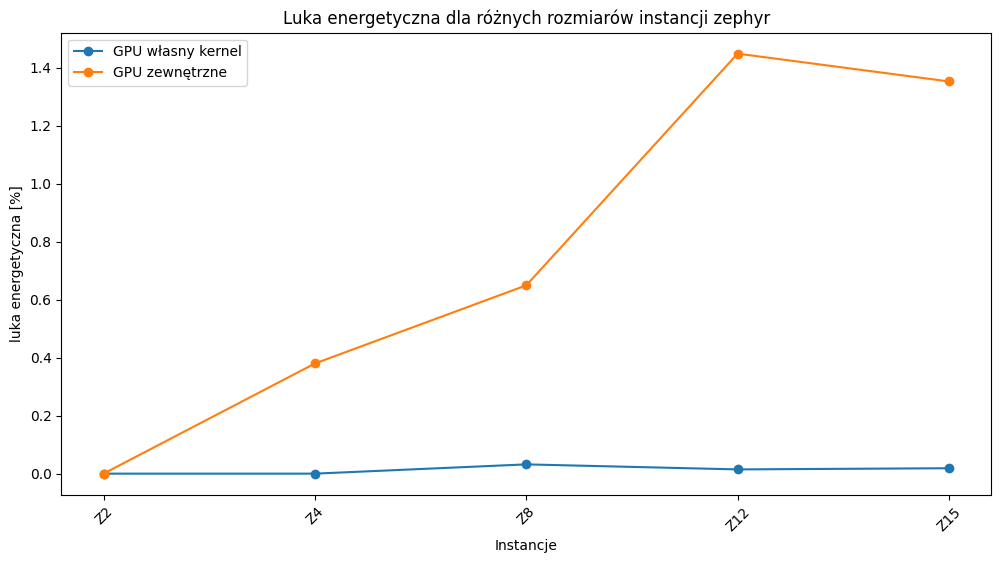

In [4]:
# Rysowanie wykresów

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from benchmark_data import ROOT, pegasus_data, chimera_data, zephyr_data


for architecture in ["chimera", "pegasus", "zephyr"]:

    with open(os.path.join(ROOT, "wyniki", f"sbm_our_{architecture}_results.pkl"), "rb") as f:
        times, gaps = pickle.load(f)

    with open(os.path.join(ROOT, "wyniki", f"sbm_external_{architecture}_results.pkl"), "rb") as f:
        times2, gaps2 = pickle.load(f)
        
    if architecture == "chimera":
        instancje = [inst.name for inst in chimera_data]

    elif architecture =="pegasus":
        instancje = [inst.name for inst in pegasus_data]

    else:
        instancje = [inst.name for inst in zephyr_data]


    x = np.arange(len(instancje))
    width = 0.25
    offset = 0.15

    fig, ax = plt.subplots(figsize=(12, 6))

    #rects2 = ax.bar(x, global_results[1], width, label='GPU naiwne')
    rects3 = ax.bar(x + offset, times, width, label='GPU wlasny kernel')
    rects4 = ax.bar(x - offset, times2, width, label='GPU zewnęczne')

    ax.set_xlabel("Instancje")
    ax.set_ylabel("Czas [s]")
    ax.set_title(f"Czas do znalezienia rozwiązania dla achitektury {architecture}")
    ax.set_xticks(x)
    ax.set_xticklabels(instancje, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(12, 6))

    gaps_procent = [x * 100 for x in gaps]
    gaps2_procent = [x * 100 for x in gaps2]
    ax2.plot(x, gaps_procent, label='GPU własny kernel', marker='o', linestyle='-')
    ax2.plot(x, gaps2_procent, label='GPU zewnętrzne', marker='o', linestyle='-')
  
    ax2.set_xlabel("Instancje")
    ax2.set_ylabel("luka energetyczna [%]")
    ax2.set_title(f"Luka energetyczna dla różnych rozmiarów instancji {architecture}")
    ax2.set_xticks(x)
    ax2.set_xticklabels(instancje, rotation=45)
    ax2.legend()
    plt.show()



 

In [2]:
######
# Komórka WIP może nie działać
#####

import torch
import simulated_bifurcation as sb
import numpy as np
from benchmark_data import P16, read_instance



J1, h1 = read_instance(P16.path, convention="dwave")

J1 = torch.tensor(J1, dtype=torch.float32, device=torch.device("cuda"))
h1 = torch.tensor(h1, dtype=torch.float32, device=torch.device("cuda"))

sb.set_env(time_step=0.5)
states, energies = sb.minimize(J1, h1, domain="spin", dtype=torch.float32, agents=2**11, mode="discrete", device=torch.device("cuda"))
print(energies.item())

🏁 Bifurcated agents: 100%|█████████▉| 2047/2048 [01:31<00:00, 22.35 agents/s]

-12570.0


# Brute Force

Pierwsze kilka komórek tworzy dane potrzebne do benchmarku, a ostatnia rysuje wykres

In [ ]:
##############################
# Uruchom tą komórkę z kernelem "bruteforce"
##############################

# Tworzenie danych dla omnisolver-bruteforce

import time
import os
import pickle
import numpy as np
from dimod import BinaryQuadraticModel
from tqdm import tqdm
from omnisolver.bruteforce.gpu.sampler import BruteforceGPUSampler

sampler = BruteforceGPUSampler()

# Kompilacja jądra CUDA
suffix_size = 10
threadsperblock = 256
blockspergrid = 2**(suffix_size)//threadsperblock

Q = np.random.uniform(-1, 1, size=(10, 10))
Q = np.triu(Q)
bqm = BinaryQuadraticModel(Q, vartype="BINARY")
sampler.sample(bqm, num_states=10, suffix_size=suffix_size, grid_size=blockspergrid, 
                   block_size=threadsperblock, dtype=np.float32)


# utworzenie danych
times = []
for n in tqdm(range(10, 41)):
    Q = np.random.uniform(-1, 1, size=(n, n))
    Q = np.triu(Q)
    bqm = BinaryQuadraticModel(Q, vartype="BINARY")


    suffix_size = min(n, 21)
    threadsperblock = 512
    blockspergrid = 2**(suffix_size)//threadsperblock
    
    start = time.time()
    sampler.sample(bqm, num_states=10, suffix_size=suffix_size, grid_size=blockspergrid, 
                   block_size=threadsperblock, dtype=np.float32)
    end = time.time()
    times.append(end - start)

with open(os.path.join("wyniki", "omnisolver_bruteforce_results.pkl"), "wb") as f:
    pickle.dump(times, f)


100%|██████████| 31/31 [08:04<00:00, 15.64s/it] 


In [ ]:
# Tworzenie danych dla naszej implementacji na GPU

import time
import os
import pickle
import cupy as cp

from benchmarks import brute_force_gpu
from tqdm import tqdm
from IPython.utils.io import capture_output

# Kompilacja
Q = cp.random.uniform(-1, 1, size=(10, 10), dtype=cp.float32)
Q = cp.triu(Q)
brute_force_gpu(Q, 10)

times = []
for n in tqdm(range(10, 41)):
    Q = cp.random.uniform(-1, 1, size=(n, n), dtype=cp.float32)
    Q = cp.triu(Q)
    start = time.time()
    with capture_output() as captured:
        brute_force_gpu(Q, num_states=10, sweep_size_exponent=min(n, 21), threadsperblock=512)
    end = time.time()
    times.append(end - start)

with open(os.path.join("wyniki", "bruteforce_results.pkl"), "wb") as f:
    pickle.dump(times, f)

100%|██████████| 31/31 [37:49<00:00, 73.21s/it] 


In [ ]:
# Tworzenie danych dla naiwnej implementacji na CPU

import time
import os
import pickle
import numpy as np

from benchmarks import brute_force_naive
from tqdm import tqdm
from IPython.utils.io import capture_output


times = []
n_range = list(range(10, 27))
for n in tqdm(n_range, desc="Wyczerpujące przeszukiwanie dla różnych n"):

    J = np.triu(np.random.uniform(-1, 1, size=(n, n)), k=1)  # losowa gęsta macierz górnotrójkątna
    h = np.random.uniform(-1, 1, size=n)  # losowy wektor
    start = time.time()
    with capture_output() as captured:
        state, energy = brute_force_naive(J, h)
    end = time.time()
    elapsed = end - start
    times.append(elapsed)

with open(os.path.join("wyniki", "bruteforce_cpu_results.pkl"), "wb") as f:
    pickle.dump(times, f)

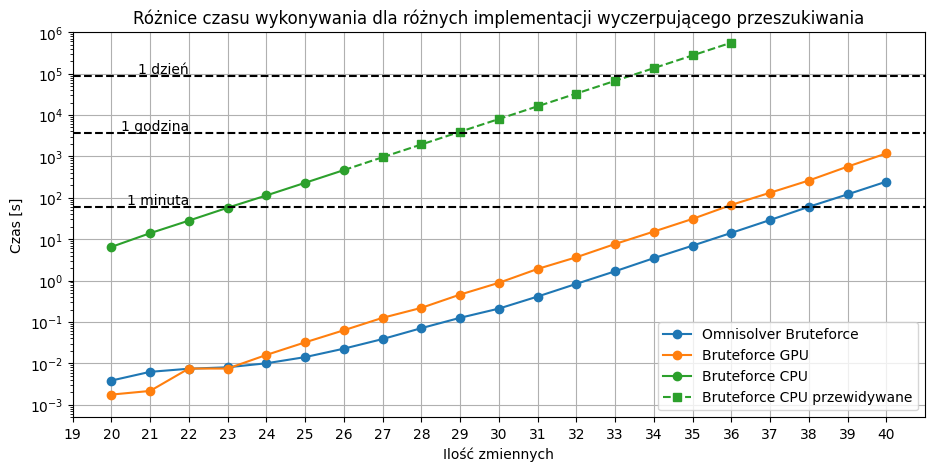

In [36]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

with open(os.path.join("wyniki", "bruteforce_results.pkl"), "rb") as f:
    times_bf = pickle.load(f)

with open(os.path.join("wyniki", "omnisolver_bruteforce_results.pkl"), "rb") as f:
    times_omnisolver = pickle.load(f)

with open(os.path.join("wyniki", "bruteforce_cpu_results.pkl"), "rb") as f:
    times_bf_cpu = pickle.load(f)

# Predykcja wartości dla CPU
x = np.array(list(range(20, 27))).reshape(-1, 1)
y = np.log(times_bf_cpu[10:])
model = LinearRegression().fit(x, y)

x_extended = np.arange(27, 37).reshape(-1, 1)
y_log_pred = model.predict(x_extended)
y_pred = np.exp(y_log_pred)

x1 = list(range(20, 41))
x2 = list(range(20, 41))
x3 = list(range(20, 27))

minute = 60
hour = 60 * 60
day = 60 * 60 * 24

plt.figure(figsize=(11, 5))
plt.plot(x1, times_omnisolver[10:], label='Omnisolver Bruteforce', marker='o', linestyle='-')
plt.plot(x2, times_bf[10:], label='Bruteforce GPU', marker='o', linestyle='-')
plt.plot(x3, times_bf_cpu[10:], label='Bruteforce CPU', marker='o', linestyle='-')
plt.plot([26, 27], [times_bf_cpu[16], y_pred[0]], linestyle='--', color='#2ca02c')
plt.plot(x_extended, y_pred, label="Bruteforce CPU przewidywane", marker="s", linestyle="--", color="#2ca02c")

plt.xticks([19] + list(range(20, 41)))
plt.yscale('log', base=10)
plt.ylim(5 * 10**-4, 10**6)

plt.axhline(minute, color='black', linestyle='--')
plt.axhline(hour, color='black', linestyle='--')
plt.axhline(day, color='black', linestyle='--')

x_min, x_max = plt.xlim()
x_label = x_min + 3

# Add text labels above the lines
plt.text(x_label, minute, '1 minuta', color='black', va='bottom', ha='right')
plt.text(x_label, hour, '1 godzina', color='black', va='bottom', ha='right')
plt.text(x_label, day, '1 dzień', color='black', va='bottom', ha='right')


plt.xlabel('Ilość zmiennych')
plt.ylabel('Czas [s]')
plt.title('Różnice czasu wykonywania dla różnych implementacji wyczerpującego przeszukiwania')
plt.legend()
plt.grid(True)
plt.show()

Jak widać z wykresu, naiwna implementacja nawet dla stosunkowo małych problemów (34 zmienne) staje się bezużyteczna. Warto zauważyć, że nasza implementacja nie odstaje aż tak drastycznie od bardzo zoptymalizowanej. 
